In [1]:
import os
from itertools import zip_longest

import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from utils.mushrooms import get_train_data, get_test_dataloader, get_train_dataloader
from utils.model import LogisticRegression
from utils.optim import GD
from utils.worker import setup_workers, update_worker_models
# from utils.worker import setup_workers
from utils.accuracy import compute_accuracy_mushrooms

graphs_dir = "./graphs"
os.makedirs(graphs_dir, exist_ok=True)
train_dataset = get_train_data()

In [2]:
model = LogisticRegression(input_size=train_dataset.X.shape[1], num_classes=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = GD(model.parameters(), lr=0.1, weight_decay=0.1)

testloader = get_test_dataloader()
num_workers = 1
workers = setup_workers(
    original_model=model,
    criterion=criterion,
    dataset=train_dataset, 
    num_workers=num_workers,
    batch_size=train_dataset.X.shape[0]//num_workers + 1
)


Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

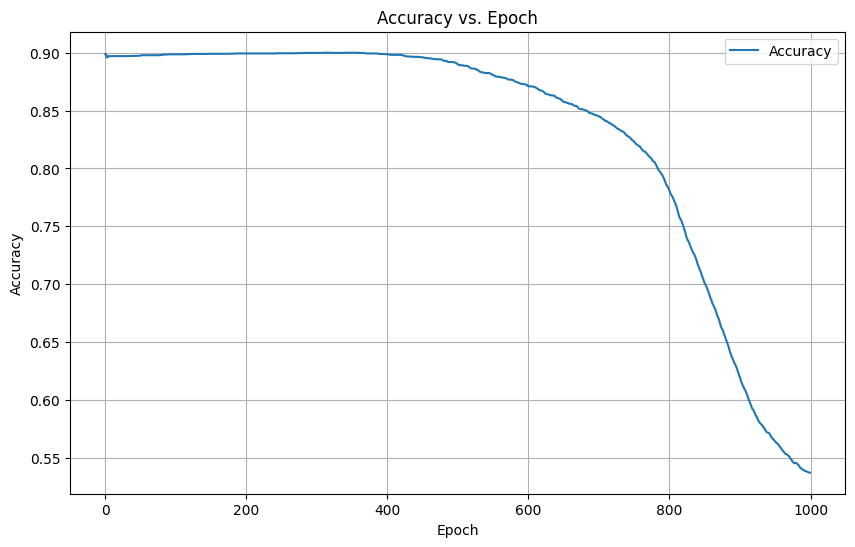

Training completed.


In [3]:
num_epochs = 1000
accuracies = []
train_loader = get_train_dataloader()

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}")
    for grads_tuple in zip_longest(*[worker.gradient_generator() for worker in workers]):
        update_worker_models(workers, model)
        optimizer.zero_grad()
        num_grads = sum(1 for _ in filter(None, grads_tuple))
        if num_grads == 0:
            continue
        for grads in filter(None, grads_tuple):
            for name, param in model.named_parameters():
                if grads[name] is not None:
                    if param.grad is None:
                        param.grad = grads[name] / num_grads
                    else:
                        param.grad += grads[name] / num_grads

        optimizer.step()
    accuracies.append(compute_accuracy_mushrooms(model, train_dataset))

plt.figure(figsize=(10, 6))
plt.plot(accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

print("Training completed.")
